# This is Jennifer's first pass at the data to do EDA

### EDA and preprocesssing

In [52]:
from glob import glob
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [53]:
file_path = ('data/track_features/tf_mini.csv')
track_features = pd.read_csv(file_path)
track_features.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [54]:
track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
track_id                  50704 non-null object
duration                  50704 non-null float64
release_year              50704 non-null int64
us_popularity_estimate    50704 non-null float64
acousticness              50704 non-null float64
beat_strength             50704 non-null float64
bounciness                50704 non-null float64
danceability              50704 non-null float64
dyn_range_mean            50704 non-null float64
energy                    50704 non-null float64
flatness                  50704 non-null float64
instrumentalness          50704 non-null float64
key                       50704 non-null int64
liveness                  50704 non-null float64
loudness                  50704 non-null float64
mechanism                 50704 non-null float64
mode                      50704 non-null object
organism                  50704 non-null float64
speechiness    

In [55]:
log_mini_path = 'data/training_set/log_mini.csv'
log_mini = pd.read_csv(log_mini_path)
# log_mini.head()

In [56]:
# what is the distribution of skipping

# plt.hist((log_mini.groupby('session_id')['skip_1'].sum()/log_mini.groupby('session_id')['session_length'].max()), bins = 20, alpha = 0.5, color = 'g')
# plt.hist((log_mini.groupby('session_id')['skip_2'].sum()/log_mini.groupby('session_id')['session_length'].max()), bins = 20, alpha = 0.5, color = 'blue')
# plt.hist((log_mini.groupby('session_id')['skip_3'].sum()/log_mini.groupby('session_id')['session_length'].max()), bins = 20, alpha = 0.5, color = 'purple')

# plt.show();

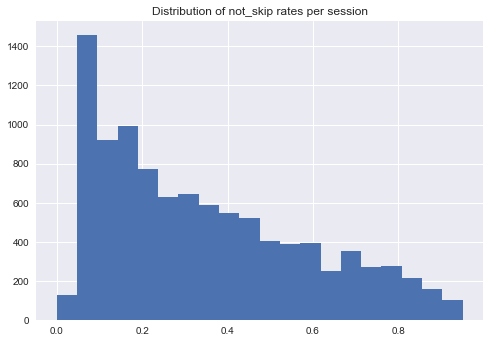

In [57]:
plt.hist((log_mini.groupby('session_id')['not_skipped'].sum()/log_mini.groupby('session_id')['session_length'].max()) , bins = 20)
plt.title('Distribution of not_skip rates per session')

plt.show();

In [58]:
np.mean(log_mini.groupby('session_id')['not_skipped'].sum()/log_mini.groupby('session_id')['session_length'].max())

# this tells me that on average, people are listening to a third of the session to completion

0.33973226547403534

In [59]:
# log_mini.session_length.unique() # this tells me that I need to normalize the skip rate with the session length

In [60]:
log_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 21 columns):
session_id                         167880 non-null object
session_position                   167880 non-null int64
session_length                     167880 non-null int64
track_id_clean                     167880 non-null object
skip_1                             167880 non-null bool
skip_2                             167880 non-null bool
skip_3                             167880 non-null bool
not_skipped                        167880 non-null bool
context_switch                     167880 non-null int64
no_pause_before_play               167880 non-null int64
short_pause_before_play            167880 non-null int64
long_pause_before_play             167880 non-null int64
hist_user_behavior_n_seekfwd       167880 non-null int64
hist_user_behavior_n_seekback      167880 non-null int64
hist_user_behavior_is_shuffle      167880 non-null bool
hour_of_day                        16

In [61]:
# I would be interested in turning the date into a datetime object and then 
# extracting the weekday to see if there is some seasonality happening
from datetime import datetime as dt

log_mini.date = pd.to_datetime(log_mini.date)
log_mini['weekday'] = log_mini.date.dt.dayofweek # Return the day of the week as an integer, where Monday is 0 and Sunday is 6

# this also means that I'm going to need to get dummy variables from weekday since it's categorical
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['weekday'], prefix = 'weekday', drop_first = True)], axis = 1)
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['hour_of_day'], prefix = 'hour', drop_first = True)], axis = 1)
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['session_position'], prefix = 'sess_pos', drop_first = True)], axis = 1)
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['hist_user_behavior_reason_start'], prefix = 'start_hist_b', drop_first = True)], axis = 1)
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['hist_user_behavior_reason_end'], prefix = 'end_hist_b', drop_first = True)], axis = 1)
log_mini = pd.concat([log_mini, pd.get_dummies(log_mini['context_type'], prefix = 'context', drop_first = True)], axis = 1)


log_mini.drop(['weekday', 'hour_of_day', 'session_position', 'context_type', 'date','track_id_clean', 'track_id',
               'session_id','short_pause_before_play', 'long_pause_before_play',
               'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'], axis = 1, inplace = True, errors = 'ignore')



Upon initial reading, I thought the problem was a classification problem in which we're asked to predict whether a user will skip this song or not (binary outcome). Now that I look at the df some more, I see that there are varying degrees of 'skip'. I think I'm going to try to simplify this problem first, and delve deeper when I've made modelling progress.

let's first get familiar with the data by looking at the data for one session log

In [62]:
# session_log_mask = (log_mini.session_id == log_mini.session_id[0])
# one_session = log_mini[session_log_mask]
# one_session_detailed = pd.merge(one_session, track_features, how = 'left', left_on='track_id_clean', right_on = 'track_id')

In [63]:
# to simplify this problem I only care about if they played the entire song or not (skip def)
# one_session_detailed.drop(['skip_1', 'skip_2', 'skip_3', 'session_id', 'track_id_clean', 'track_id'], axis = 1, 
#                           inplace = True, errors = 'ignore')

In [64]:
# one_session_detailed.info()
# my target feature is 'not_skipped'

In [65]:
# i want to see the distribution of songs that play all the way through


# plt.hist(log_mini.groupby('session_id')['not_skipped'].sum(), bins = 20)
# plt.title('Distribution of songs that were not skipped per session')
# plt.show();

In [66]:
# I want to make sure to compare it against a dummy classifier so i can establish a baseline
# i need to scale things

log_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 78 columns):
session_length                   167880 non-null int64
skip_1                           167880 non-null bool
skip_2                           167880 non-null bool
skip_3                           167880 non-null bool
not_skipped                      167880 non-null bool
context_switch                   167880 non-null int64
no_pause_before_play             167880 non-null int64
hist_user_behavior_n_seekfwd     167880 non-null int64
hist_user_behavior_n_seekback    167880 non-null int64
hist_user_behavior_is_shuffle    167880 non-null bool
premium                          167880 non-null bool
weekday_1                        167880 non-null uint8
weekday_2                        167880 non-null uint8
weekday_3                        167880 non-null uint8
weekday_4                        167880 non-null uint8
weekday_5                        167880 non-null uint8
weekday_6      

### Modelling

Recall, we are trying to predict 'not_skipped' aka played the entire song

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Feature ranking with recursive feature elimination.
from sklearn.feature_selection import RFE

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

x_features = log_mini.drop(['not_skipped'], axis = 1)
y_target = log_mini.not_skipped

# frmo experience running before scaling, scaling doesn't change the metrics but doing it for good measure
scaler = StandardScaler()
x_transformed = scaler.fit_transform(x_features)
x_features = pd.DataFrame(x_transformed, columns = x_features.columns)
x_features.head()

,session_length,skip_1,skip_2,skip_3,context_switch,no_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,end_hist_b_endplay,end_hist_b_fwdbtn,end_hist_b_logout,end_hist_b_remote,end_hist_b_trackdone,context_charts,context_editorial_playlist,context_personalized_playlist,context_radio,context_user_collection
0,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,-1.817405,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.38184,-0.121469,1.925461,-0.134339,-0.379219,-0.819316
1,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,0.550235,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.38184,-0.121469,1.925461,-0.134339,-0.379219,-0.819316
2,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,0.550235,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.38184,-0.121469,1.925461,-0.134339,-0.379219,-0.819316
3,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,0.550235,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.38184,-0.121469,1.925461,-0.134339,-0.379219,-0.819316
4,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,0.550235,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.38184,-0.121469,1.925461,-0.134339,-0.379219,-0.819316


In [68]:
# sm = SMOTE(random_state=42) #this takes a long time so i would suggest saving to pkl and loading the pkl
# x_res, y_res = sm.fit_sample(x_features, y_target)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target)

In [73]:
# x_train

,session_length,skip_1,skip_2,skip_3,context_switch,no_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,end_hist_b_endplay,end_hist_b_fwdbtn,end_hist_b_logout,end_hist_b_remote,end_hist_b_trackdone,context_charts,context_editorial_playlist,context_personalized_playlist,context_radio,context_user_collection
101888,-1.651607,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,0.483664,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,-0.379219,1.220530
76363,0.686197,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,-2.067551,...,3.213354,-0.970057,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,-0.379219,-0.819316
19568,0.686197,-0.853592,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,-2.067551,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,1.925461,-0.134339,-0.379219,-0.819316
45038,-1.651607,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,0.483664,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,2.636998,-0.819316
71066,-0.190479,-0.853592,-1.034969,-1.357931,-0.206516,0.550235,-0.105933,-0.076265,1.496346,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.381840,-0.121469,-0.519356,-0.134339,-0.379219,1.220530
84715,-0.190479,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,0.483664,...,3.213354,-0.970057,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,-0.379219,-0.819316
88774,0.686197,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,0.483664,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,-0.379219,-0.819316
65276,-0.482705,-0.853592,0.966213,0.736414,-0.206516,-1.817405,-0.105933,-0.076265,-0.668295,0.483664,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,2.636998,-0.819316
105244,0.686197,-0.853592,-1.034969,-1.357931,-0.206516,-1.817405,-0.105933,-0.076265,-0.668295,0.483664,...,-0.311201,-0.970057,-0.058008,-0.039912,1.381840,-0.121469,-0.519356,-0.134339,-0.379219,1.220530
85566,-1.067156,1.171520,0.966213,0.736414,-0.206516,0.550235,-0.105933,-0.076265,-0.668295,-2.067551,...,-0.311201,1.030867,-0.058008,-0.039912,-0.723673,-0.121469,-0.519356,-0.134339,-0.379219,1.220530


In [69]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(x_train, y_train)
print(accuracy_score(dummy_classifier.predict(x_test), y_test))
confusion_matrix(dummy_classifier.predict(x_test), y_test)
# scaler = StandardScaler()
# x_features = scaler.fit_transform(x_features)

0.5559923755063141


array([[18639,  9197],
       [ 9352,  4782]])

This is because it's an imbalanced dataset lmao

In [70]:
lr_model = LogisticRegression()
# selector = RFE(lr_model, 10) # this takes hella long to run nevermind
lr_model.fit(x_train, y_train)
accuracy_score(lr_model.predict(x_test), y_test)

0.9919704550869669

In [71]:
# sorted(list(zip(lr_model.coef_[0], x_features.columns)), key= lambda x: abs(x[0]), reverse = True)
lr_coef_df = pd.DataFrame(list(zip(lr_model.coef_[0], x_features.columns)))
lr_coef_df['coef_abs'] = abs(lr_coef_df.iloc[:,0])
lr_coef_df.sort_values('coef_abs', ascending= False, inplace = True)
lr_coef_df.head()

,0,1,coef_abs
3,-7.003413,skip_3,7.003413
71,3.107486,end_hist_b_trackdone,3.107486
1,2.774953,skip_1,2.774953
2,-1.420742,skip_2,1.420742
64,1.256391,start_hist_b_trackdone,1.256391


In [72]:
# I would be interested to see how well i can predict if i just had the skip_3 column

In [85]:
skip_3_lr = LogisticRegression()
skip_3_lr.fit(x_train[['skip_3']], y_train)
accuracy_score(skip_3_lr.predict(x_test[['skip_3']]), y_test)

0.9813438170121516

In [91]:
(confusion_matrix(skip_3_lr.predict(x_test[['skip_3']]), y_test))
# why is that even with just this one variable, i am able to get 98% accuracy..

# recall that skip_3 indicates that if false, most of the song was played

array([[27208,     0],
       [  783, 13979]])

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

ya know, i never did explore if premium users are different from not-premium users. i would be interested to see if there is clustering possible.